# Mobile Payment Fraud Detection

In [35]:
import numpy as np
import pandas as pd

import pickle 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [36]:
import pandas as pd

data = pd.read_csv('/Users/shivangisingh/Desktop/mobile-fraud-detection/.venv/dataset/PS_20174392719_1491204439457_log.csv', nrows=50000)

In [37]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [38]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            50000 non-null  int64  
 1   type            50000 non-null  object 
 2   amount          50000 non-null  float64
 3   nameOrig        50000 non-null  object 
 4   oldbalanceOrg   50000 non-null  float64
 5   newbalanceOrig  50000 non-null  float64
 6   nameDest        50000 non-null  object 
 7   oldbalanceDest  50000 non-null  float64
 8   newbalanceDest  50000 non-null  float64
 9   isFraud         50000 non-null  int64  
 10  isFlaggedFraud  50000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 4.2+ MB


In [39]:
data['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [40]:
data['isFraud'].value_counts()

isFraud
0    49900
1      100
Name: count, dtype: int64

# Preprocessing    

In [41]:
#One hot encoding
pd.get_dummies(data['type'], prefix='type').astype(int)

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,1,0
...,...,...,...,...,...
49995,0,0,0,1,0
49996,0,0,0,1,0
49997,0,0,0,1,0
49998,0,0,0,1,0


In [42]:
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
49995,9,PAYMENT,1322.91,C1402545110,1208457.61,1207134.71,M578074960,0.0,0.0,0,0
49996,9,PAYMENT,6900.48,C517372485,1207134.71,1200234.22,M1854114037,0.0,0.0,0,0
49997,9,PAYMENT,17399.12,C1948160352,1200234.22,1182835.10,M1940330634,0.0,0.0,0,0
49998,9,PAYMENT,5485.20,C1586381033,1182835.10,1177349.90,M741912557,0.0,0.0,0,0


In [43]:
{column: len(data[column].unique()) for column in data.columns}

{'step': 9,
 'type': 5,
 'amount': 49786,
 'nameOrig': 50000,
 'oldbalanceOrg': 30572,
 'newbalanceOrig': 24328,
 'nameDest': 28499,
 'oldbalanceDest': 25369,
 'newbalanceDest': 9367,
 'isFraud': 2,
 'isFlaggedFraud': 1}

In [44]:
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [45]:
def preprocess_inputs(df):
    df = df.copy()
    
    
    # Drop step, nameOrig, and isFlaggedFraud columns
    df = df.drop(['step', 'nameOrig', 'isFlaggedFraud'], axis=1)
    
    
    # One-hot encode the type column
    df = onehot_encode(df, column='type', prefix='')
    
    y = df['isFraud'].copy()
    X = df.drop('isFraud', axis=1).copy()
    
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    
    # Create a tokenizer and fit it to the customer data
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(X_train['nameDest'])
    
    print("Total # of customers:", len(tokenizer.word_index))

    # Save the tokenizer
    with open('tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)
    
    # Create tokenized customer lists
    customers_train = tokenizer.texts_to_sequences(X_train['nameDest'])
    customers_test = tokenizer.texts_to_sequences(X_test['nameDest'])
    
    
    # Pad sequences
    customers_train = tf.keras.preprocessing.sequence.pad_sequences(customers_train, maxlen=1)
    customers_test = tf.keras.preprocessing.sequence.pad_sequences(customers_test, maxlen=1)
    
    
    # Drop nameDest column
    X_train = X_train.drop('nameDest', axis=1)
    X_test = X_test.drop('nameDest', axis=1)
    
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    # Save the scaler (already done)
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    
    
    return X_train, X_test, customers_train, customers_test, y_train, y_test

In [46]:
X_train, X_test, customers_train, customers_test, y_train, y_test = preprocess_inputs(data)

Total # of customers: 21017


In [47]:
customers_train


array([[ 3450],
       [ 3451],
       [  579],
       ...,
       [ 1149],
       [  685],
       [21017]], dtype=int32)

In [48]:
X_train

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,_CASH_IN,_CASH_OUT,_DEBIT,_PAYMENT,_TRANSFER
0,-0.476533,-0.331007,-0.333246,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425
1,-0.473382,-0.325069,-0.327862,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425
2,0.659963,0.315640,0.469088,2.728245,2.704851,2.147900,-0.618309,-0.115403,-0.880868,-0.324425
3,2.643818,-0.258553,-0.333403,2.149973,3.096149,-0.465571,-0.618309,-0.115403,-0.880868,3.082377
4,-0.476656,-0.322919,-0.325276,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425
...,...,...,...,...,...,...,...,...,...,...
34995,-0.282179,-0.332726,-0.333403,-0.312612,-0.378779,-0.465571,1.617313,-0.115403,-0.880868,-0.324425
34996,-0.193468,-0.332726,-0.333403,-0.250166,-0.231651,-0.465571,1.617313,-0.115403,-0.880868,-0.324425
34997,-0.045903,-0.330860,-0.268056,-0.131990,-0.134482,2.147900,-0.618309,-0.115403,-0.880868,-0.324425
34998,-0.474906,-0.332726,-0.333403,-0.071037,-0.237439,-0.465571,1.617313,-0.115403,-0.880868,-0.324425


In [49]:
y_train

17325    0
13544    0
49844    0
16371    0
13084    0
        ..
7763     0
15377    0
17730    0
28030    0
15725    0
Name: isFraud, Length: 35000, dtype: int64

# Handling class imbalance

In [50]:
train_df = pd.concat([X_train, pd.Series(np.squeeze(customers_train), name='customer'), y_train.reset_index(drop=True)], axis=1)

In [51]:
train_df

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,_CASH_IN,_CASH_OUT,_DEBIT,_PAYMENT,_TRANSFER,customer,isFraud
0,-0.476533,-0.331007,-0.333246,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425,3450,0
1,-0.473382,-0.325069,-0.327862,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425,3451,0
2,0.659963,0.315640,0.469088,2.728245,2.704851,2.147900,-0.618309,-0.115403,-0.880868,-0.324425,579,0
3,2.643818,-0.258553,-0.333403,2.149973,3.096149,-0.465571,-0.618309,-0.115403,-0.880868,3.082377,146,0
4,-0.476656,-0.322919,-0.325276,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425,3452,0
...,...,...,...,...,...,...,...,...,...,...,...,...
34995,-0.282179,-0.332726,-0.333403,-0.312612,-0.378779,-0.465571,1.617313,-0.115403,-0.880868,-0.324425,399,0
34996,-0.193468,-0.332726,-0.333403,-0.250166,-0.231651,-0.465571,1.617313,-0.115403,-0.880868,-0.324425,304,0
34997,-0.045903,-0.330860,-0.268056,-0.131990,-0.134482,2.147900,-0.618309,-0.115403,-0.880868,-0.324425,1149,0
34998,-0.474906,-0.332726,-0.333403,-0.071037,-0.237439,-0.465571,1.617313,-0.115403,-0.880868,-0.324425,685,0


In [52]:
train_df['isFraud'].value_counts()

isFraud
0    34929
1       71
Name: count, dtype: int64

In [53]:
print("Number of examples to sample:", 34929 - 71)

Number of examples to sample: 34858


In [54]:
oversampled_data = train_df.query("isFraud == 1").sample(34858, replace=True, random_state=123)

In [55]:
oversampled_data

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,_CASH_IN,_CASH_OUT,_DEBIT,_PAYMENT,_TRANSFER,customer,isFraud
33821,-0.408856,-0.321259,-0.333403,-0.343521,-0.388017,-0.465571,1.617313,-0.115403,-0.880868,-0.324425,1428,1
11627,-0.454176,-0.327894,-0.333403,-0.332356,-0.391365,-0.465571,1.617313,-0.115403,-0.880868,-0.324425,2108,1
28865,0.188942,-0.233736,-0.333403,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,-0.880868,3.082377,1378,1
23959,2.522990,0.107987,-0.333403,-0.292894,-0.024354,-0.465571,1.617313,-0.115403,-0.880868,-0.324425,55,1
18502,-0.454256,-0.327906,-0.333403,-0.347251,-0.396106,-0.465571,1.617313,-0.115403,-0.880868,-0.324425,358,1
...,...,...,...,...,...,...,...,...,...,...,...,...
20572,-0.451855,-0.327554,-0.333403,-0.347251,-0.296089,-0.465571,1.617313,-0.115403,-0.880868,-0.324425,3181,1
7264,-0.207165,-0.291730,-0.333403,-0.338556,-0.399715,-0.465571,1.617313,-0.115403,-0.880868,-0.324425,7133,1
15636,-0.486670,-0.332651,-0.333403,-0.345580,-0.399715,-0.465571,1.617313,-0.115403,-0.880868,-0.324425,11307,1
14302,3.502961,0.251463,-0.333403,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,-0.880868,3.082377,1920,1


In [56]:
train_df = pd.concat([train_df, oversampled_data], axis=0).sample(frac=1.0, random_state=123).reset_index(drop=True)

In [57]:
train_df

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,_CASH_IN,_CASH_OUT,_DEBIT,_PAYMENT,_TRANSFER,customer,isFraud
0,-0.455241,-0.328050,-0.333403,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,-0.880868,3.082377,13802,1
1,-0.433171,1.673388,1.646507,-0.299754,-0.366017,2.147900,-0.618309,-0.115403,-0.880868,-0.324425,1030,0
2,-0.474980,-0.309417,-0.312245,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425,3572,0
3,-0.388713,-0.332726,-0.333403,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425,5835,0
4,-0.469634,-0.332726,-0.333403,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425,4713,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69853,-0.444370,-0.326458,-0.333403,-0.345862,-0.350505,-0.465571,1.617313,-0.115403,-0.880868,-0.324425,2342,1
69854,-0.455568,-0.328098,-0.333403,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,-0.880868,3.082377,8999,1
69855,-0.453397,-0.332726,-0.333403,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425,12402,0
69856,-0.442919,-0.088634,-0.099816,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425,17568,0


In [58]:
train_df['isFraud'].value_counts()

isFraud
1    34929
0    34929
Name: count, dtype: int64

In [59]:
customers_train = train_df['customer'].copy()
y_train = train_df['isFraud'].copy()
X_train = train_df.drop(['customer', 'isFraud'], axis=1).copy()

# Modeling

In [60]:
# Inputs
X_inputs = tf.keras.Input(shape=(10,), name='X_input')
customer_inputs = tf.keras.Input(shape=(1,), name='customer_input')

# X
X_dense1 = tf.keras.layers.Dense(64, activation='relu', name='X_dense1')(X_inputs)
X_dense2 = tf.keras.layers.Dense(64, activation='relu', name='X_dense2')(X_dense1)

# customers
customer_embedding = tf.keras.layers.Embedding(
    input_dim=21018,
    output_dim=64,
    input_length=1,
    name='customer_embedding'
)(customer_inputs)
customer_flatten = tf.keras.layers.Flatten(name='customer_flatten')(customer_embedding)

# Concatenate
concat = tf.keras.layers.concatenate([X_dense2, customer_flatten], name='concatenate')

# Output
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(concat)


model = tf.keras.Model(inputs=[X_inputs, customer_inputs], outputs=outputs)

print(model.summary())
#tf.keras.utils.plot_model(model, show_shapes=True, rankdir='TB')

/Users/shivangisingh/Desktop/mobile-fraud-detection/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ X_input             │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ customer_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ X_dense1 (Dense)    │ (None, 64)        │        704 │ X_input[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ customer_embedding  │ (None, 1, 64)     │  1,345,152 │ customer_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ X_dense2 (Dense)    │ (None, 64)        │      4,160 │ X_dense1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ customer_flatten    │ (None, 64)        │          0 │ customer_embeddi… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ X_dense2[0][0],   │
│ (Concatenate)       │                   │            │ customer_flatten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        129 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,350,145 (5.15 MB)

 Trainable params: 1,350,145 (5.15 MB)

 Non-trainable params: 0 (0.00 B)

None


In [61]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

# Training

In [62]:
history = model.fit(
    [X_train, customers_train],
    y_train,
    validation_split=0.2,
    class_weight={
        0: 0.25,
        1: 4.0
    },
    batch_size=32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8390 - auc: 0.9587 - loss: 0.1851 - val_accuracy: 0.9979 - val_auc: 0.9991 - val_loss: 0.0114
Epoch 2/10
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9982 - auc: 0.9990 - loss: 0.0033 - val_accuracy: 0.9985 - val_auc: 0.9998 - val_loss: 0.0067
Epoch 3/10
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9983 - auc: 0.9989 - loss: 0.0033 - val_accuracy: 0.9985 - val_auc: 0.9996 - val_loss: 0.0066
Epoch 4/10
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9983 - auc: 0.9988 - loss: 0.0034 - val_accuracy: 0.9986 - val_auc: 0.9994 - val_loss: 0.0091
Epoch 5/10
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9985 - auc: 0.9992 - loss: 0.0026 - val_accuracy: 0.9986 - val_auc: 0.9994 - val_loss: 0.0086


### Saving the Model

In [63]:
# Save the entire model to a HDF5 file
model.save('my_model.keras')

# Result

In [64]:
results = model.evaluate([X_test, customers_test], y_test, verbose=0)
print("Test Accuracy: {:.3f}%".format(results[1] * 100))
print("     Test AUC: {:.3f}".format(results[2] * 100))

Test Accuracy: 99.687%
     Test AUC: 78.935


In [65]:
y_true = np.array(y_test)

y_pred = np.squeeze(model.predict([X_test, customers_test]))
y_pred = (y_pred >= 0.5).astype(int)


cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names=["Not Fraud", "Fraud"])

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step


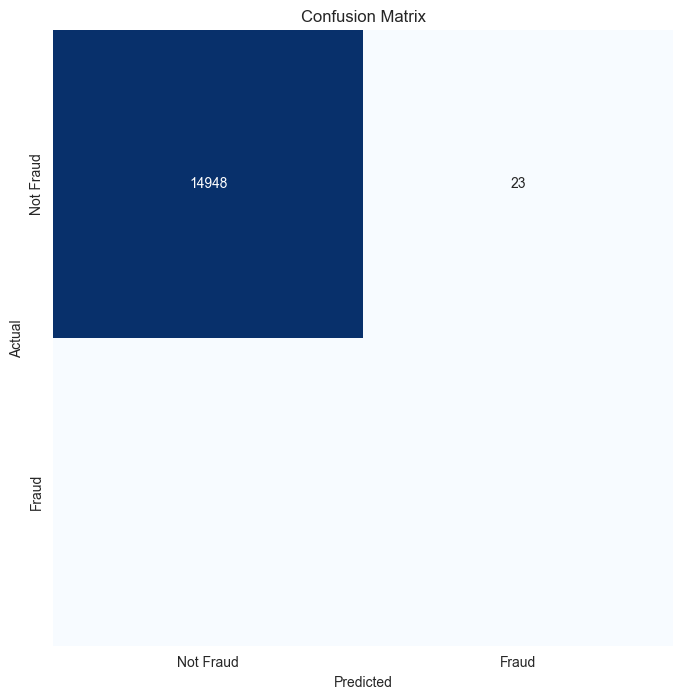

In [66]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(2) + 0.5, ["Not Fraud", "Fraud"])
plt.yticks(np.arange(2) + 0.5, ["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [67]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     14971
       Fraud       0.18      0.17      0.18        29

    accuracy                           1.00     15000
   macro avg       0.59      0.59      0.59     15000
weighted avg       1.00      1.00      1.00     15000

